# Week 2:Day 1
## Feature Engineering & Complete EDA

In [60]:
#Import Libraries
import pandas as pd # Data processing
import matplotlib.pyplot as plt # Data Visualization
import numpy as np # Array operations
import seaborn as sns # Data Visualization

In [61]:
#Load cleaned dataset
claims_complete = pd.read_excel('Data/cleaned_claims_dataset_.xlsx')

In [62]:
#Viewing the structure of the dataset

claims_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Claim_ID                      8000 non-null   object        
 1   Policy_ID                     8000 non-null   object        
 2   Accident_Date                 8000 non-null   datetime64[ns]
 3   FNOL_Date                     8000 non-null   datetime64[ns]
 4   Claim_Type                    8000 non-null   object        
 5   Claim_Complexity              8000 non-null   object        
 6   Fraud_Flag                    8000 non-null   bool          
 7   Litigation_Flag               8000 non-null   bool          
 8   Estimated_Claim_Amount        8000 non-null   int64         
 9   Ultimate_Claim_Amount         8000 non-null   float64       
 10  Severity_Band                 8000 non-null   object        
 11  Settlement_Date               

In [63]:
# Correcting the data types issues

#Changing the data type of Claim_Type, Claim_Complexity, Severity_Band, Status, Gender, Occupation, Region, Vehicle_Type and Credit_Score_Band from objects to Category
#Changing the data type of Accident_Date, FNOL_Date and Settlement_Date from objects to Datetime

claims_complete["Claim_Type"] = claims_complete["Claim_Type"].astype("category")  
claims_complete["Claim_Complexity"] = claims_complete["Claim_Complexity"].astype("category")
claims_complete["Severity_Band"] = claims_complete["Severity_Band"].astype("category")
claims_complete["Status"] = claims_complete["Status"].astype("category")
claims_complete["Gender"] = claims_complete["Gender"].astype("category")
claims_complete["Occupation"] = claims_complete["Occupation"].astype("category")
claims_complete["Region"] = claims_complete["Region"].astype("category")
claims_complete["Vehicle_Type"] = claims_complete["Vehicle_Type"].astype("category")
claims_complete["Credit_Score_Band"] = claims_complete["Credit_Score_Band"].astype("category")
claims_complete['Settlement_Date'] = pd.to_datetime(claims_complete['Settlement_Date'], errors='coerce')
claims_complete['Accident_Date'] = pd.to_datetime(claims_complete['Accident_Date'], errors='coerce')
claims_complete['FNOL_Date'] = pd.to_datetime(claims_complete['FNOL_Date'], errors='coerce')

#Confirming if the datatypes have been changed.
claims_complete.info()

#NB:the below results confirms the data types have been successfully changed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Claim_ID                      8000 non-null   object        
 1   Policy_ID                     8000 non-null   object        
 2   Accident_Date                 8000 non-null   datetime64[ns]
 3   FNOL_Date                     8000 non-null   datetime64[ns]
 4   Claim_Type                    8000 non-null   category      
 5   Claim_Complexity              8000 non-null   category      
 6   Fraud_Flag                    8000 non-null   bool          
 7   Litigation_Flag               8000 non-null   bool          
 8   Estimated_Claim_Amount        8000 non-null   int64         
 9   Ultimate_Claim_Amount         8000 non-null   float64       
 10  Severity_Band                 8000 non-null   category      
 11  Settlement_Date               

### Feature Engineering

#### Determining the number of days between accident & FNOL

In [64]:
# Determining the number of days between accident & FNOL

claims_complete['Days_Accident_to_FNOL'] = (
    claims_complete['FNOL_Date'] - claims_complete['Accident_Date']
).dt.days

#Checking sample data
claims_complete['Days_Accident_to_FNOL'].head()

#Insight:
        # 0 = same day reporting
        # Positive values = delayed reporting
        # Negative values = data quality issue (FNOL before accident)

0    0
1    1
2    0
3    0
4    3
Name: Days_Accident_to_FNOL, dtype: int64

In [65]:
# Quick validation checks

claims_complete['Days_Accident_to_FNOL'].describe()

#the below result shows an outlier of 30 days which should be a claim of interest.

count    8000.000000
mean        1.769375
std         3.179340
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        30.000000
Name: Days_Accident_to_FNOL, dtype: float64

In [66]:
# Quick check if there are negative values

claims_complete[claims_complete['Days_Accident_to_FNOL'] < 0]

# The below result show there are no negative values in the Days_Accident_to_FNOL column

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,...,Credit_Score_Band,num_third_parties,max_injury_severity,has_minor,has_serious,has_fatality,has_pedestrian,has_passenger,has_driver,Days_Accident_to_FNOL


In [67]:
#Capping to handle the outliers in the column

cap = claims_complete['Days_Accident_to_FNOL'].quantile(0.99)

claims_complete['Days_Accident_to_FNOL_Capped'] = (
    claims_complete['Days_Accident_to_FNOL']
    .clip(upper=cap)
)

#### Asessing the Vehicle Risk

In [68]:
# Quick check on the data for the Vehicle Age column
claims_complete['Vehicle_Age'].describe()

# The result below shows a minimum of 0 years which means the vehicle is brand new in the year of the accident.
#There are no record of negative years or vehicles above 50 years

count    8000.000000
mean       10.039500
std         6.105477
min         0.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        20.000000
Name: Vehicle_Age, dtype: float64

In [69]:
# Creating vehicle age bands

claims_complete['Vehicle_Age_Band'] = pd.cut(
    claims_complete['Vehicle_Age'],
    bins=[-0.1, 3, 7, 12, 20, 50],
    labels=['0–3', '4–7', '8–12', '13–20', '20+'],
    right=True
)

In [70]:
# Measure actual risk

vehicle_risk_table = (
    claims_complete
    .groupby(['Vehicle_Type', 'Vehicle_Age_Band'], observed=True)
    ['Ultimate_Claim_Amount']
    .median()
    .reset_index()
)

vehicle_risk_table

,Vehicle_Type,Vehicle_Age_Band,Ultimate_Claim_Amount
0,Coupe,0–3,3055.00
1,Coupe,4–7,3218.00
2,Coupe,8–12,3065.50
3,Coupe,13–20,3194.00
4,Hatchback,0–3,3689.25
5,Hatchback,4–7,3458.00
6,Hatchback,8–12,3177.00
7,Hatchback,13–20,2990.50
8,Motorcycle,0–3,2580.00
9,Motorcycle,4–7,3859.00


In [71]:
# Normalising the vehicle risk score

min_risk = vehicle_risk_table['Ultimate_Claim_Amount'].min()
max_risk = vehicle_risk_table['Ultimate_Claim_Amount'].max()

vehicle_risk_table['Vehicle_Risk_Score'] = (
    (vehicle_risk_table['Ultimate_Claim_Amount'] - min_risk)
    / (max_risk - min_risk)
)

vehicle_risk_table['Vehicle_Risk_Score']

0     0.371384
1     0.498827
2     0.379593
3     0.480063
4     0.867279
5     0.686474
6     0.466771
7     0.320954
8     0.000000
9     1.000000
10    0.376075
11    0.126661
12    0.656763
13    0.993354
14    0.868256
15    0.474590
16    0.489445
17    0.637998
18    0.858874
19    0.490227
20    0.867866
21    0.498045
22    0.347146
23    0.863370
Name: Vehicle_Risk_Score, dtype: float64

In [72]:
# Adding the Vehicle risk score feature to the dataset 

claims_complete = claims_complete.merge(
    vehicle_risk_table[
        ['Vehicle_Type', 'Vehicle_Age_Band', 'Vehicle_Risk_Score']
    ],
    on=['Vehicle_Type', 'Vehicle_Age_Band'],
    how='left'
)

In [73]:
# Validate risk using severity statistics

severity_summary = (
    claims_complete
    .groupby(
        ['Vehicle_Type', 'Vehicle_Age_Band'],
        observed=True
    )['Ultimate_Claim_Amount_Capped']
    .agg(
        count='count',
        median='median',
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95)
    )
    .reset_index()
)

severity_summary

,Vehicle_Type,Vehicle_Age_Band,count,median,p90,p95
0,Coupe,0–3,151,3055.00,35463.0,43311.00
1,Coupe,4–7,162,3218.00,28381.8,47119.40
2,Coupe,8–12,176,3065.50,23705.0,46695.75
3,Coupe,13–20,355,3194.00,32156.2,51900.90
4,Hatchback,0–3,382,3689.25,30111.0,48268.00
5,Hatchback,4–7,309,3458.00,32276.4,56793.80
6,Hatchback,8–12,417,3177.00,22957.3,46137.40
7,Hatchback,13–20,768,2990.50,25425.0,47403.00
8,Motorcycle,0–3,58,2580.00,15331.7,28273.90
9,Motorcycle,4–7,85,3859.00,26071.6,46569.60


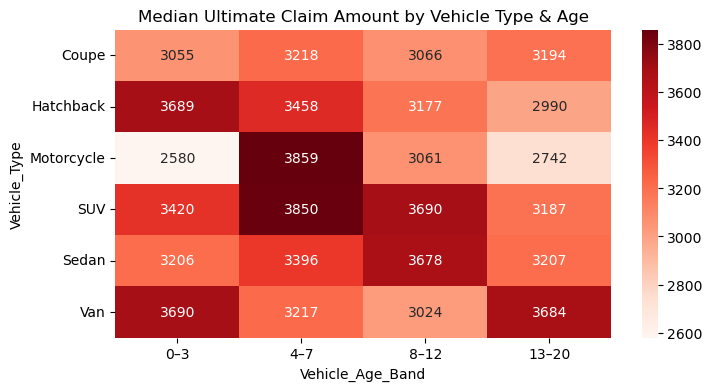

In [74]:
# Heatmap on the severity_summary results.

pivot = severity_summary.pivot(
    index='Vehicle_Type',
    columns='Vehicle_Age_Band',
    values='median'
)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Reds')
plt.title('Median Ultimate Claim Amount by Vehicle Type & Age')
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Median Ultimate Claim Amount by Vehicle Type & Age.png', dpi=300, bbox_inches='tight')
plt.show()

#Insight:

        # Highest vehicle risks with respect to vehicle age 
        
        # Motorcycle (0–3 years): 4,316 → highest overall
        # Motorcycle (4–7 years): 3,859
                # Highest severity when new
                # Severity declines with age (likely value depreciation)
                # Still above many vehicle types even when older
        
        # SUV (4–7 years): 3,850
                # Likely due to expensive parts still in use
        
        # Van (13–20 years): 3,684
                # Likely due to Commercial usage and Mechanical failure
        
        # Lowest vehicle risks with respect to vehicle age 
        
        # Coupe (0–3 years)
        
        # Hatchback (13–20 years)

#### Asessing the Driver Risk

In [75]:
# Quick check on the data for the Age_of_Driver column
claims_complete['Age_of_Driver'].describe()

#the minimum age is 18. There are no data errors of negative numbers

count    8000.000000
mean       48.928125
std        17.902298
min        18.000000
25%        33.000000
50%        49.000000
75%        65.000000
max        79.000000
Name: Age_of_Driver, dtype: float64

In [76]:
# Quick check on the data for the Driving_Experience_Years column
claims_complete['Driving_Experience_Years'].describe()

#the minimum years of experience is 0. This may indicate newly licensed drivers. There are no data errors of negative numbers

count    8000.000000
mean       29.003250
std        17.850576
min         0.000000
25%        14.000000
50%        29.000000
75%        45.000000
max        61.000000
Name: Driving_Experience_Years, dtype: float64

In [77]:
# Creating Driver age bands

claims_complete['Driver_Age_Band'] = pd.cut(
    claims_complete['Age_of_Driver'],
    bins=[17, 24, 34, 49, 64, 120],
    labels=['18–24', '25–34', '35–49', '50–64', '65+']
)

In [78]:
# Creating Driver experience bands

claims_complete['Driving_Experience_Band'] = pd.cut(
    claims_complete['Driving_Experience_Years'],
    bins=[-1, 1, 5, 10, 20, np.inf],
    labels=['0–1', '2–5', '6–10', '11–20', '21+']
)

In [79]:
# Measure actual risk

risk_table = (
    claims_complete
    .groupby(['Driver_Age_Band', 'Driving_Experience_Band'], observed=True)
    ['Ultimate_Claim_Amount']
    .median()
    .unstack()
)

risk_table

# The result below shows that Drivers aged 25-34 with 6-10 driving experinces recorded the highest risk

Driving_Experience_Band,0–1,2–5,6–10,11–20,21+
Driver_Age_Band,,,,,
18–24,3058.0,3523.5,2184.0,NaN,NaN
25–34,NaN,3024.0,3616.0,3350.0,NaN
35–49,NaN,NaN,NaN,3559.0,3186.0
50–64,NaN,NaN,NaN,NaN,3409.0
65+,NaN,NaN,NaN,NaN,3181.0


In [80]:
#Convert severity into a risk score

risk_score = (
    (risk_table - risk_table.min().min()) /
    (risk_table.max().max() - risk_table.min().min())
) * 4 + 1

risk_score = risk_score.round(1)

risk_score

# The result below shows that Drivers aged 25-34 with 6-10 driving experinces recorded the highest risk

Driving_Experience_Band,0–1,2–5,6–10,11–20,21+
Driver_Age_Band,,,,,
18–24,3.4,4.7,1.0,NaN,NaN
25–34,NaN,3.3,5.0,4.3,NaN
35–49,NaN,NaN,NaN,4.8,3.8
50–64,NaN,NaN,NaN,NaN,4.4
65+,NaN,NaN,NaN,NaN,3.8


In [81]:
# Create a single driver risk feature
claims_complete['Driver_Risk_Score'] = claims_complete.apply(
    lambda r: risk_score.loc[
        r['Driver_Age_Band'],
        r['Driving_Experience_Band']
    ]
    if pd.notnull(r['Driver_Age_Band']) and pd.notnull(r['Driving_Experience_Band'])
    else np.nan,
    axis=1
)

claims_complete['Driver_Risk_Score']

0       4.4
1       3.8
2       3.4
3       3.3
4       5.0
       ... 
7995    4.8
7996    4.4
7997    4.3
7998    4.8
7999    4.8
Name: Driver_Risk_Score, Length: 8000, dtype: float64

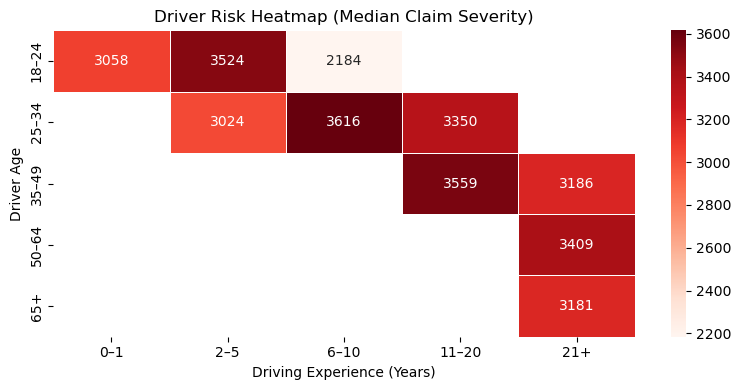

In [82]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    risk_table,
    annot=True,
    fmt='.0f',
    cmap='Reds',
    linewidths=0.5
)

plt.title('Driver Risk Heatmap (Median Claim Severity)')
plt.xlabel('Driving Experience (Years)')
plt.ylabel('Driver Age')
plt.tight_layout()
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Driver Risk Heatmap(Median Claim Severity).png', dpi=300, bbox_inches='tight')
plt.show()

# Insight:
# Highest risk zones
# Age	Experience	Median Severity	Interpretation
# 18–24	2–5 yrs	3524	Young drivers with some confidence → risky
# 25–34	6–10 yrs	3616	Fast driving + exposure
# 35–49	11–20 yrs	3559	High mileage, work-related driving
# 50–64	21+ yrs	3409	Age-related reaction decline

# Lower risk zones
# Age	Experience	Median Severity
# 18–24	6–10 yrs	2184
# 25–34	2–5 yrs	3024


#### Assessing severity by seasons

In [83]:
#Mapping months to seasons

def map_season(month):
    if month in [12, 1, 2]:
        return 'Dry'
    elif month in [3, 4, 5]:
        return 'Pre-Rain'
    elif month in [6, 7, 8, 9]:
        return 'Rainy'
    else:
        return 'Post-Rain'

claims_complete['Accident_Season'] = (
    claims_complete['Accident_Date']
    .dt.month
    .apply(map_season)
)

claims_complete['Accident_Season'] 

0             Dry
1             Dry
2       Post-Rain
3           Rainy
4        Pre-Rain
          ...    
7995     Pre-Rain
7996        Rainy
7997    Post-Rain
7998          Dry
7999     Pre-Rain
Name: Accident_Season, Length: 8000, dtype: object

In [84]:
# Compare median severity by season

season_severity = (
    claims_complete
    .groupby('Accident_Season')['Ultimate_Claim_Amount']
    .median()
    .sort_values(ascending=False)
)

season_severity

#The result below shows the most severe seasons are Post-rain

Accident_Season
Post-Rain    3388.0
Rainy        3346.0
Pre-Rain     3309.0
Dry          3209.5
Name: Ultimate_Claim_Amount, dtype: float64

### EDA

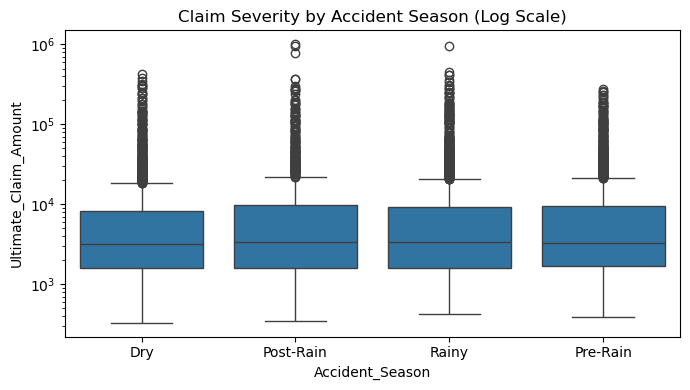

In [85]:
#Boxplot to show severity by seasons
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=claims_complete,
    x='Accident_Season',
    y='Ultimate_Claim_Amount'
)

plt.yscale('log')
plt.title('Claim Severity by Accident Season (Log Scale)')
plt.tight_layout()
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Claim Severity by Accident Season(Log Scale).png', dpi=300, bbox_inches='tight')
plt.show()

# The distributions of ultimate claim amounts are very similar across all four accident seasons.
# Neither the median cost nor the typical variability, shows a significant difference between the dry, rainy, or transitional periods.
# The presence of extreme high-value claims(outliers) shows severe seasons are Post-rain and Rainy

#### Asessing the Third Party Severity Score

In [86]:
# Map Severity_Band to numeric severity weights

severity_band_weights = {
    'Minor': 1,
    'Moderate': 2,
    'Major': 4,
    'Severe': 7,
    'Catastrophic': 10
}

In [87]:
# Convert severity band to numeric
claims_complete['Severity_Weight'] = (
    claims_complete['Severity_Band']
    .map(severity_band_weights)
    .astype(float)

)

In [88]:
# Combining severity with number of third parties

claims_complete['ThirdParty_Severity_Score'] = (
    claims_complete['Severity_Weight']
    * np.log1p(claims_complete['num_third_parties'])
)

In [89]:
#Normalising the score

claims_complete['ThirdParty_Severity_Score_Norm'] = (
    claims_complete['ThirdParty_Severity_Score']
    / claims_complete['ThirdParty_Severity_Score'].max()
)

claims_complete['ThirdParty_Severity_Score_Norm']

# Insight:

# Score	    Meaning
# 0.00	    No third-party involvement
# 0.10–0.25	Minor injury, 1 party
# 0.30–0.50	Major injury, multiple parties
# 0.50–1.00	Catastrophic injury, many parties

0       0.063093
1       0.000000
2       0.630930
3       0.000000
4       0.000000
          ...   
7995    0.000000
7996    0.000000
7997    0.000000
7998    0.000000
7999    0.000000
Name: ThirdParty_Severity_Score_Norm, Length: 8000, dtype: float64

#### Asessing the location risk

In [90]:
# Aggregate severity by region

region_risk_table = (
    claims_complete
    .groupby('Region', observed=True)
    .agg(
        median_severity=('Ultimate_Claim_Amount', 'median'),
        claim_count=('Claim_ID', 'count')
    )
    .reset_index()
)

region_risk_table

# the min< median and the Ultimate Claim Amount data is Long right tail so we need to do a credibility adjustment

,Region,median_severity,claim_count
0,Birmingham,3152.0,737
1,Bristol,3384.0,816
2,Cardiff,3389.0,768
3,Edinburgh,3236.5,816
4,Glasgow,3637.0,899
5,Leeds,3062.0,747
6,Liverpool,3193.0,836
7,London,3403.0,808
8,Manchester,3516.0,783
9,Newcastle,3245.0,790


In [91]:
# Credibility adjustment
# This code applies credibility weighting so that regions with limited data are not over- or under-estimated in claim severity risk.

global_median = claims_complete['Ultimate_Claim_Amount'].median()
k = 100  # credibility threshold

region_risk_table['Credible_Severity'] = (
    (region_risk_table['claim_count'] /
     (region_risk_table['claim_count'] + k))
    * region_risk_table['median_severity']
    +
    (k /
     (region_risk_table['claim_count'] + k))
    * global_median
)

region_risk_table['Credible_Severity']

0    3170.697730
1    3375.757642
2    3379.725806
3    3244.360262
4    3604.117117
5    3091.102715
6    3205.339744
7    3392.592511
8    3492.500566
9    3252.134831
Name: Credible_Severity, dtype: float64

In [92]:
# Normalize to 0–1

min_val = region_risk_table['Credible_Severity'].min()
max_val = region_risk_table['Credible_Severity'].max()

region_risk_table['Region_Risk_Score'] = (
    (region_risk_table['Credible_Severity'] - min_val)
    / (max_val - min_val)
)

region_risk_table['Region_Risk_Score']

0    0.155152
1    0.554867
2    0.562602
3    0.298739
4    1.000000
5    0.000000
6    0.222678
7    0.587683
8    0.782430
9    0.313894
Name: Region_Risk_Score, dtype: float64

In [93]:
# Merge back

claims_complete = claims_complete.merge(
    region_risk_table[['Region', 'Region_Risk_Score']],
    on='Region',
    how='left'
)

claims_complete['Region_Risk_Score'] = (
    claims_complete['Region_Risk_Score']
    .fillna(region_risk_table['Region_Risk_Score'].median())
)

#### Comparing claim costs across Claim_Type

In [94]:
# Summary statistics by Claim_Type

claim_type_summary = (
    claims_complete
    .groupby('Claim_Type', observed=True)['Ultimate_Claim_Amount']
    .agg(
        count='count',
        median='median',
        mean='mean',
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95)
    )
    .sort_values('median', ascending=False)
)

claim_type_summary

#From the results below:

#Fire
#Low frequency, very high severity
#Drives capital & reinsurance risk
#Fire claims are catastrophic, not frequent.

#Collision
#Many claims, but relatively low cost
#Collision drives workload, not capital risk.

#Theft
#Medium frequency, large tail losses
#Theft risk escalates quickly in large claims.

#Weather & Other
#Moderate severity and frequency

#Vandalism
#Low cost, predictable

,count,median,mean,p90,p95
Claim_Type,,,,,
Fire,425,22947.5,55711.118824,113839.2,243804.80
Theft,811,6836.5,20635.089396,35268.0,84517.00
Weather,1193,3719.0,11578.283319,22279.2,52055.00
Other,404,3690.5,12350.334158,27998.0,51011.15
Collision,4394,2540.0,8691.923532,19229.5,36549.65
Vandalism,773,1556.5,4880.992885,9011.8,20692.80


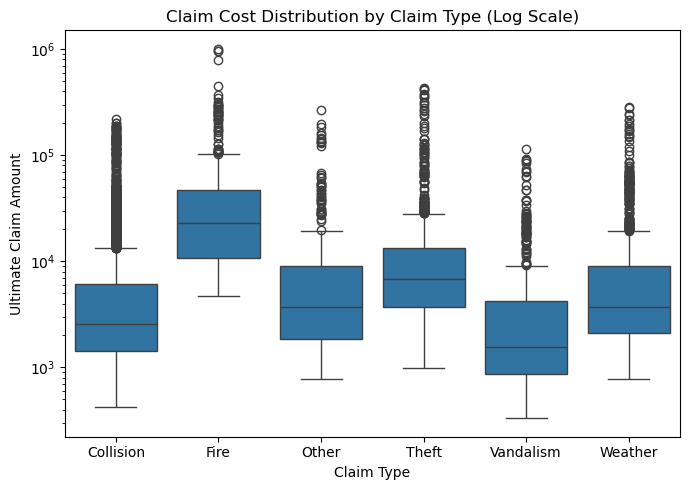

In [95]:
# Boxplot on log scale

plt.figure(figsize=(7, 5))
sns.boxplot(
    data=claims_complete,
    x='Claim_Type',
    y='Ultimate_Claim_Amount'
)

plt.yscale('log')
plt.title('Claim Cost Distribution by Claim Type (Log Scale)')
plt.xlabel('Claim Type')
plt.ylabel('Ultimate Claim Amount')
plt.tight_layout()
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Claim Cost Distribution by Claim Type (Log Scale).png', dpi=300, bbox_inches='tight')
plt.show()

#From the graph below:
# While median costs vary, the data suggests that Collision and Fire claims are associated with the most significant high-cost events and variability.


<Figure size 800x500 with 0 Axes>

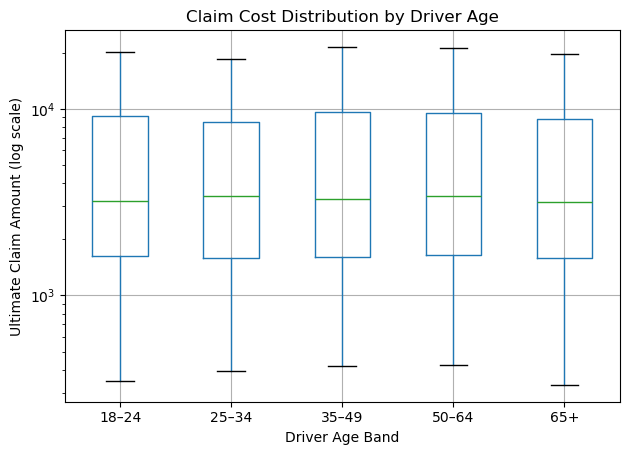

In [96]:
#Boxplot of Driver age vrs Ultimate Claim Amount

plt.figure(figsize=(8, 5))
claims_complete.boxplot(
    column='Ultimate_Claim_Amount',
    by='Driver_Age_Band',
    showfliers=False
)
plt.yscale('log')

plt.xlabel('Driver Age Band')
plt.ylabel('Ultimate Claim Amount (log scale)')
plt.title('Claim Cost Distribution by Driver Age')
plt.suptitle('')
plt.tight_layout()
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Claim Cost Distribution by Driver Age.png', dpi=300, bbox_inches='tight')
plt.show()

# Driver age alone is not a strong severity driver
# Driver age alone shows limited separation in claim severity. Risk emerges primarily through interactions with experience, vehicle characteristics, and third-party involvement.

<Figure size 1000x500 with 0 Axes>

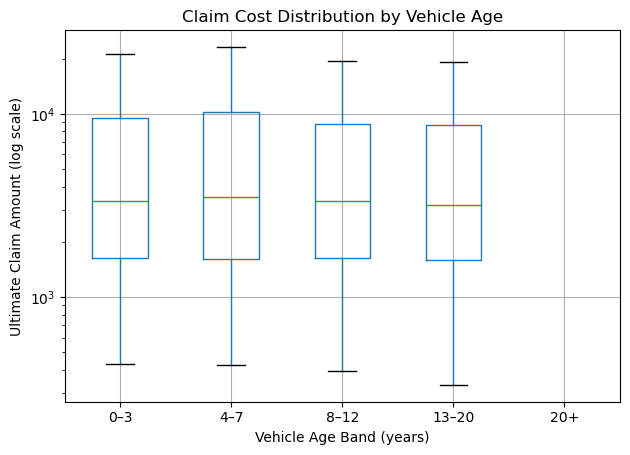

In [97]:
#Boxplot for Vehicle age vs cost

plt.figure(figsize=(10, 5))
claims_complete.boxplot(
    column='Ultimate_Claim_Amount',
    by='Vehicle_Age_Band',
    showfliers=False
)
plt.yscale('log')

plt.xlabel('Vehicle Age Band (years)')
plt.ylabel('Ultimate Claim Amount (log scale)')
plt.title('Claim Cost Distribution by Vehicle Age')
plt.suptitle('')
plt.tight_layout()
plt.show()

# From the results below:

# Medians are not flat
# 4–7 years has the highest median
# 0–3 and 8–12 slightly lower
# 13–20 continues to decline

# Mid-aged vehicles (4–7 years) exhibit the highest median claim costs, reflecting high repair complexity after warranty expiry

<Figure size 800x500 with 0 Axes>

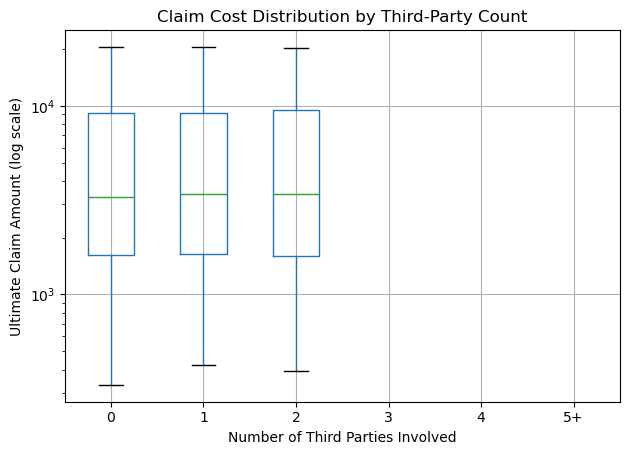

In [98]:
# Boxplot for thirdparty count vrs cost

#Creating count bands
claims_complete['TP_Count_Band'] = pd.cut(
    claims_complete['num_third_parties'],
    bins=[-0.1, 0, 1, 2, 3, 4, 100],
    labels=['0', '1', '2', '3','4', '5+']
)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
claims_complete.boxplot(
    column='Ultimate_Claim_Amount',
    by='TP_Count_Band',
    showfliers=False
)
plt.yscale('log')

plt.xlabel('Number of Third Parties Involved')
plt.ylabel('Ultimate Claim Amount (log scale)')
plt.title('Claim Cost Distribution by Third-Party Count')
plt.suptitle('')
plt.tight_layout()
plt.savefig('Visualizations/Feature Engineering & Complete EDA/Calim Cost Distribution by Third-Party Count.png', dpi=300, bbox_inches='tight')
plt.show()

#From the results below:
#The median claim amount (green line) appears consistent across cases with 1, or 2 third parties involved,around the \(10^{3}\) mark. 
#The overall range and interquartile range (the box) of claim amounts are also very similar for 1, and 2 third parties.

In [102]:
#Exporting claims_complete data to excel.

claims_complete.to_excel(
     'Data/cleaned_claims_dataset_added_features.xlsx',
    index=False
)

In [100]:
# Viewing the final dataset

claims_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Claim_ID                        8000 non-null   object        
 1   Policy_ID                       8000 non-null   object        
 2   Accident_Date                   8000 non-null   datetime64[ns]
 3   FNOL_Date                       8000 non-null   datetime64[ns]
 4   Claim_Type                      8000 non-null   category      
 5   Claim_Complexity                8000 non-null   category      
 6   Fraud_Flag                      8000 non-null   bool          
 7   Litigation_Flag                 8000 non-null   bool          
 8   Estimated_Claim_Amount          8000 non-null   int64         
 9   Ultimate_Claim_Amount           8000 non-null   float64       
 10  Severity_Band                   8000 non-null   category      
 11  Sett

## Overall Insight: Claim Severity Drivers & Business Implications

Our analysis shows that claim severity is driven far more by exposure complexity than by customer demographics. Claim costs are highly skewed, with a small proportion of claims accounting for a disproportionate share of total losses. As a result, median and tail metrics (P90–P95) are more reliable indicators of risk than averages.

Claim Type is the single strongest predictor of severity. Fire claims, while relatively infrequent, represent catastrophic exposure with extreme tail losses and should be treated as a reinsurance risks rather than operational risks. Theft claims also exhibit significant tail risk, while collision claims dominate volume but remain comparatively low in severity. Vandalism is consistently the lowest-cost claim type.

Third-party involvement materially escalates claim costs. Severity increases non-linearly with the number of third parties and is amplified further by injury severity. Claims involving serious or fatal injuries represent step-changes in exposure due to medical, legal, and settlement complexity. This makes third-party exposure one of the most powerful levers for severity prediction.

Vehicle characteristics affects severity, particularly for motorcycles, SUVs, and vans. In contrast, risk emerges primarily through interactions with driving experience and exposure factors.


## Recommendations

### Underwriting & Pricing
Introduce explicit severity loadings for Fire and Theft claims.
Price for third-party exposure using both count and injury severity.
Apply non-linear vehicle age and vehicle type adjustments.

### Risk Management
Treat Fire claims as capital risk requiring reinsurance optimization.
Flag high third-party and injury-driven claims early for proactive handling.

### Claims Strategy
Prioritize early intervention on claims with multiple third parties or severe injuries.
Use FNOL delay and exposure complexity to triage high-severity cases.